In [5]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
from PIL import Image
import torchtoolbox.transform as transforms

# Data Process

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [7]:
class MData(Dataset):
    def __init__(self,transform,
                 path_m = "C:/Users/utkua/OneDrive/Masaüstü/AI/MC/archivebig/DermMel/train_sep/Melanoma",
                 path_nm = "C:/Users/utkua/OneDrive/Masaüstü/AI/MC/archivebig/DermMel/train_sep/NotMelanoma"
                ):
        melanoma = os.listdir(path_m) 
        notmelanoma = os.listdir(path_nm) 
        print("melanoma sizze:",len(melanoma),"\nnot melanoma size:",len(notmelanoma))
        
        lst = []
        
        for m in notmelanoma:
            im_path = os.path.join(path_nm,m)
            lst.append({"path":im_path,"m":0})
            
        for m in melanoma:
            im_path = os.path.join(path_m,m)
            lst.append({"path":im_path,"m":1})
            

        df = pd.DataFrame(lst)
        #df.head(10)
        
        self.transform = transform
        self.df = df
        
    def __getitem__(self,index):
        
        ip = self.df["path"].at[index].replace("\\","/")
        #print("IPath:",ip)
        image = Image.open(ip)
        # Convert PIL image to NumPy array
        numpy_image = np.array(image)
        # Convert NumPy array to cv2 image
        cv2_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
        
        #print("IPath:",image_path)
        #x = cv2.imread(image_path)
        x = self.transform(cv2_image)
        
        x = torch.tensor(x, device=device, dtype=torch.float32).to(device)
        
        y = self.df["m"].at[index]
        y = torch.tensor(y, device=device, dtype=torch.float32).to(device)
        
        return x,y.unsqueeze(0)
        
    def __len__(self):
        return len(self.df)

In [8]:
dataset = MData(transform=train_transform)
print("TotalSize:",len(dataset))
train_loader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)#num_workers=2

melanoma sizze: 5341 
not melanoma size: 5341
TotalSize: 10682


# AI

In [9]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import cv2

In [10]:
class MNet(nn.Module):
    def __init__(self):
        super(MNet,self).__init__()
        meta_f = 9
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(131072,500),
            nn.ReLU()
        )
        self.last = nn.Sequential(
            nn.Linear(500,200),
            nn.ReLU(),
            nn.Linear(200,1),
            nn.Sigmoid()
        )
    
    def forward(self, data):
        #print("Data::",data[0].shape,"-",data[1].shape)
        pic = self.network(data)
        return self.last(pic)

# Train

In [14]:

torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MNet()
model.load_state_dict(torch.load("model_light10.1.pth"))
model.to(device)
model.eval()

MNet(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=131072, out_features=500, bias=True)
    (17): ReLU()
  )
  (last): Sequential(
    (0):

In [7]:
epochs = 1
#lr = 1e-3
lr = 0.001


optimizer = torch.optim.AdamW(model.parameters(),lr)
#crt = nn.MSELoss()

criterion = nn.BCELoss()

In [13]:
# 3rd = [Epoch:3][Loss:0.35583835080001025]
# 4th = [Epoch:4][Loss:0.2646494110654522]
# 5th = [Epoch:5][Loss:0.21910520681193377]
# 6th = [Epoch:6][Loss:0.21663773750686252]
# 7th = [Epoch:3][Loss:0.2167293639093813]
# 8th = [Epoch:4][Loss:0.18821389735772773]
# 9th = [Epoch:5][Loss:0.20160326449776617]
# 10th = [Epoch:6][Loss:0.18298539361377256]
# 11th = [Epoch:7][Loss:0.3033026327192718]
# 12nd =[Epoch:8][Loss:0.2001335004513037]
# 13rd = [Epoch:9][Loss:0.18754390212069366]
# 14th = [Epoch:0][Loss:0.16168049016476985]
bar_epoch = tqdm(total=epochs,desc="Epochs")
bar_batch = tqdm(total=len(dataset),desc="Batch")

total_loss = 0
for e in range(epochs):
    total_loss = 0
    loss_count=0
    bar_epoch.update(1)
    bar_batch.reset()
    model.train()
    
    for picture,y in train_loader:
        bar_batch.update(picture.size(0))
        
        optimizer.zero_grad()
        
        o = model(picture)
        
        loss = criterion(o,y)
        
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if loss_count%10 == 0:
            print("Loss:"+str( (total_loss/(loss_count+1)) ) )
        
        loss_count +=1
    
    print(f"[Epoch:{e}][Loss:{total_loss/loss_count}]")
    torch.save(model.state_dict(), f'./model_light{e+1+9}.pth')

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/10682 [00:00<?, ?it/s]

C:\Users\utkua\AppData\Local\Temp\ipykernel_22248\109822515.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=device, dtype=torch.float32).to(device)


Loss:0.05283601954579353
Loss:0.2853450504818201
Loss:0.19613229336989338
Loss:0.24796975396195822
Loss:0.2239609257941446
Loss:0.25180923103563546
Loss:0.25210622912225894
Loss:0.23506554972051513
Loss:0.2268462699112962
Loss:0.21041205640106259


KeyboardInterrupt: 

# Confussion Matrix

In [11]:

test_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [12]:
train_data = MData(
    test_transform,
    path_m="C:\\Users\\utkua\\OneDrive\\Masaüstü\\AI\\MC\\archivebig\\DermMel\\test\\Melanoma",
    path_nm="C:/Users/utkua/OneDrive/Masaüstü/AI/MC/archivebig/DermMel/test/NotMelanoma"
)

melanoma sizze: 1781 
not melanoma size: 1780


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
p_train, y_train = dataset.__getitem__(13)
p,y = train_data.__getitem__(13)
p=p.unsqueeze(0)
y=y.unsqueeze(0)
p_train = p_train.unsqueeze(0)
y_train = y_train.unsqueeze(0)

print(p.shape, y.shape," - ",p_train.shape,y_train.shape)

cuda
torch.Size([1, 3, 256, 256]) torch.Size([1, 1])  -  torch.Size([1, 3, 256, 256]) torch.Size([1, 1])


C:\Users\utkua\AppData\Local\Temp\ipykernel_24556\109822515.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=device, dtype=torch.float32).to(device)


In [16]:
#device ="cuda" if torch.cuda.is_available() else "cpu"
model = MNet().to(device)

def test_by_index(index):
    global model, train_data
    picture,y = train_data.__getitem__(index)
    picture=picture.unsqueeze(0)
    y=y.unsqueeze(0)
    out = model(picture)
    return "NotMelanoma" if y<0.5 else "Melanoma",bool(( 0 if out <0.5 else 1)==y)

def test_all_moduls():
    global model
    torch.cuda.empty_cache()
    lst = [f for f in os.listdir()  if f.startswith("model_light") ]
    
    bar_models = tqdm(total=len(lst),desc="models")
    bar_test = tqdm(total=len(train_data),desc="Testing")
    
    conf_lst = []
    
    for model_path in (lst):
        bar_models.update(1)
        bar_test.reset()
        torch.cuda.empty_cache()
        model.load_state_dict(torch.load(model_path))
        model.eval()
        NotMelanoma =  [0,0]
        Melanoma = [0,0]
        for i in (range(len(train_data))):
            bar_test.update(1)
            m,d = test_by_index(i)
            if m == "NotMelanoma":
                NotMelanoma[d]+=1
            elif m == "Melanoma":
                Melanoma[d]+=1
        print("MODUL PATH:",model_path,f"\n - Not Melanoma Result:(Wrong:{NotMelanoma[0]}, Correct({NotMelanoma[1]})\n - Melanoma Testing:(Wrong:{Melanoma[0]}, Correct:{Melanoma[1]}))")                     
        conf_lst.append([model_path,NotMelanoma,Melanoma])
    return conf_lst

In [17]:
conf_list = test_all_moduls()

models:   0%|          | 0/14 [00:00<?, ?it/s]

Testing:   0%|          | 0/3561 [00:00<?, ?it/s]

C:\Users\utkua\AppData\Local\Temp\ipykernel_24556\109822515.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=device, dtype=torch.float32).to(device)


MODUL PATH: model_light-1.pth 
 - Not Melanoma Result:(Wrong:910, Correct(870)
 - Melanoma Testing:(Wrong:169, Correct:1612))
MODUL PATH: model_light-2.pth 
 - Not Melanoma Result:(Wrong:1087, Correct(693)
 - Melanoma Testing:(Wrong:263, Correct:1518))
MODUL PATH: model_light0.pth 
 - Not Melanoma Result:(Wrong:425, Correct(1355)
 - Melanoma Testing:(Wrong:340, Correct:1441))
MODUL PATH: model_light1.pth 
 - Not Melanoma Result:(Wrong:198, Correct(1582)
 - Melanoma Testing:(Wrong:210, Correct:1571))
MODUL PATH: model_light10.1.pth 
 - Not Melanoma Result:(Wrong:82, Correct(1698)
 - Melanoma Testing:(Wrong:225, Correct:1556))
MODUL PATH: model_light10.2.pth 
 - Not Melanoma Result:(Wrong:131, Correct(1649)
 - Melanoma Testing:(Wrong:191, Correct:1590))
MODUL PATH: model_light2.pth 
 - Not Melanoma Result:(Wrong:186, Correct(1594)
 - Melanoma Testing:(Wrong:192, Correct:1589))
MODUL PATH: model_light3.pth 
 - Not Melanoma Result:(Wrong:218, Correct(1562)
 - Melanoma Testing:(Wrong:182, C

[[43, 1737], [233, 1548]]


<AxesSubplot:>

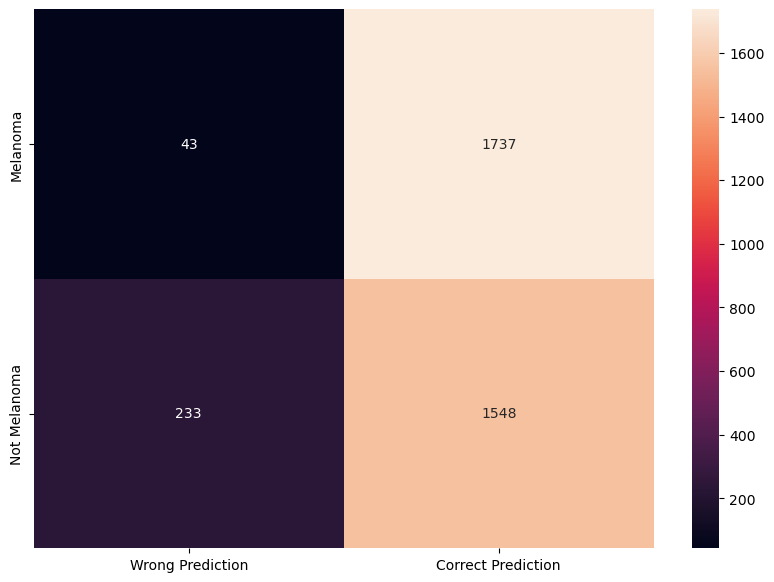

In [50]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


matrix=[
    [int(conf_list[11][1][0]),int(conf_list[11][1][1])],
        
    [conf_list[11][2][0],conf_list[11][2][1]]
       ]
print(matrix)
index=["Melanoma","Not Melanoma"]
columns = ["Wrong Prediction","Correct Prediction"]
#index.clear()
#index.append(c[0])
df_cm = pd.DataFrame(matrix, index = index,
                  columns = columns)
plt.figure(figsize = (10,7)) 
sn.heatmap(df_cm, annot=True,fmt='g')

<AxesSubplot:>

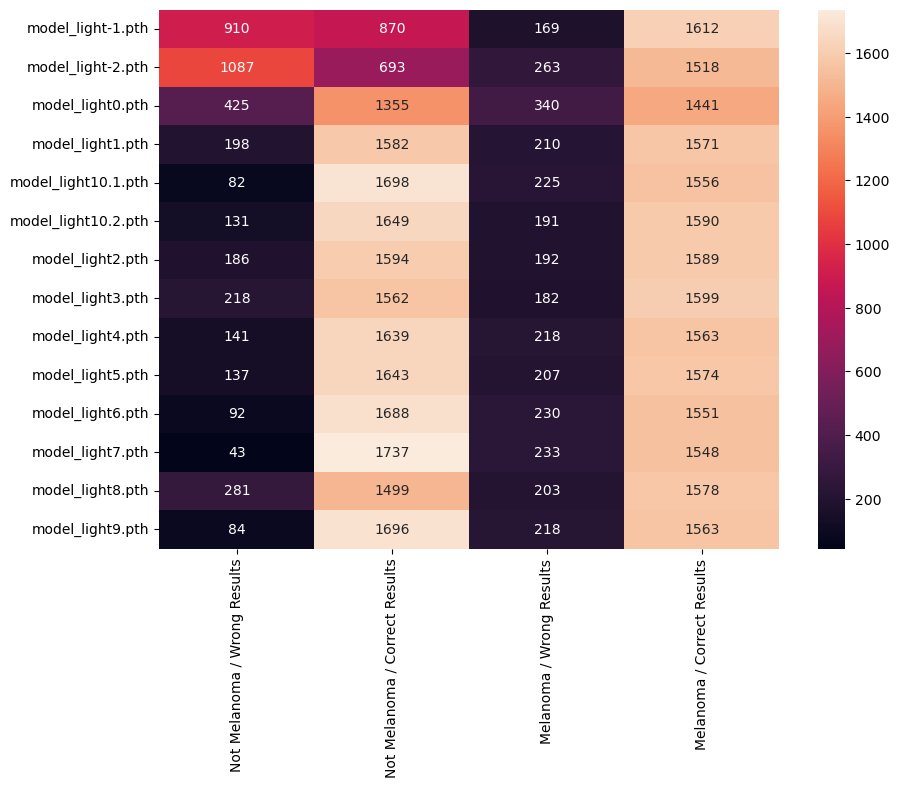

In [56]:
matrix=[]
#index=["Epoch 4:","Epoch 3:", "Epoch 5:","Epoch 6:","Epoch 15:","Epoch 16:","Epoch 7:","Epoch 8:",
#      "Epoch 9:","Epoch 10:","Epoch 11:","Epoch 12:","Epoch 13:","Epoch 14:"]
#index.clear()
index=[]
for c in conf_list:
    matrix.append([c[1][0],c[1][1],c[2][0],c[2][1]])
    index.append(c[0])
df_cm = pd.DataFrame(matrix, index = index,
                  columns = ["Not Melanoma / Wrong Results","Not Melanoma / Correct Results","Melanoma / Wrong Results","Melanoma / Correct Results"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g')

# Test Codes

ValueError: invalid literal for int() with base 10: '10.1'

In [15]:
NotMelanoma =  [0,0]
Melanoma = [0,0]
for i in tqdm(range(len(train_data)),desc="Testing"):
    m,d = test_by_index(i)
    if m == "NotMelanoma":
        NotMelanoma[d]+=1
    elif m == "Melanoma":
        Melanoma[d]+=1
print("NM:",NotMelanoma," M:",Melanoma)

Testing:   0%|          | 0/3561 [00:00<?, ?it/s]

C:\Users\utkua\AppData\Local\Temp\ipykernel_16888\109822515.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=device, dtype=torch.float32).to(device)


NM: [49, 1731]  M: [228, 1553]


In [13]:
print(f"Melanoma Accuracy(True:{Melanoma[1]} / False:{Melanoma[0]}) \nNot Melanoma Accuracy(True:{NotMelanoma[1]} / False:{NotMelanoma[0]})")             

Melanoma Accuracy(True:1585 / False:196) 
Not Melanoma Accuracy(True:1687 / False:93)


In [ ]:

"""
MODUL PATH: model_light-2.pth  - N: [963, 817]  M: [284, 1497]
MODUL PATH: model_light-1.pth  - NM: [837, 943]  M: [183, 1598]
MODUL PATH: model_light0.pth  - NM: [385, 1395]  M: [348, 1433]
MODUL PATH: model_light1.pth  - NM: [168, 1612]  M: [210, 1571]
MODUL PATH: model_light2.pth  - NM: [149, 1631]  M: [199, 1582]
MODUL PATH: model_light3.pth  - NM: [166, 1614]  M: [194, 1587]
MODUL PATH: model_light4.pth  - NM: [105, 1675]  M: [224, 1557]
MODUL PATH: model_light5.pth  - NM: [107, 1673]  M: [224, 1557]
MODUL PATH: model_light6.pth  - NM: [63, 1717]  M: [239, 1542]
MODUL PATH: model_light7.pth  - NM: [29, 1751]  M: [239, 1542]
MODUL PATH: model_light8.pth  - NM: [164, 1616]  M: [219, 1562]
MODUL PATH: model_light9.pth  - NM: [64, 1716]  M: [220, 1561]
MODUL PATH: model_light10.1.pth  - NM: [49, 1731]  M: [228, 1553]
MODUL PATH: model_light10.pth - NM: [49, 1731]  M: [228, 1553]
"""